In [1]:
# =============================================================================
# @author: Brian Kyanjo
# @date: 2024-11-06
# @description: Synthetic ice stream with data assimilation
# =============================================================================

In [2]:
# --- Synthetic ice stream example ---
import firedrake
import sys, os
import jax
import h5py
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import copy

import warnings
warnings.filterwarnings("ignore")

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [3]:
# --- Geometry and input data ---
# an elongated fjord-like geometry (12km wide and 50km from the inflow boundary to the ice front)
# Lx, Ly = 50e3, 12e3
# nx, ny = 48, 32
Lx, Ly = 50e2, 12e2
nx, ny = 12, 8
mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

x, y = firedrake.SpatialCoordinate(mesh)

# the bedrock slopes down from 200m ABS at the inflow boundary to -400m at the terminus
b_in, b_out = 200, -400
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

s_in, s_out = 850, 50
s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

h0 = firedrake.interpolate(s0 - b, Q)

# --- Evaluate the driving stress ---
from icepack.constants import (
    ice_density as rho_I,
    water_density as rho_W,
    gravity as g,
)

h_in = s_in - b_in
ds_dx = (s_out - s_in) / Lx
tau_D = -rho_I * g * h_in * ds_dx
print(f"{1000*tau_D} kPa")

# --- Guess for the initial velocity ---
u_in, u_out = 20, 2400
velocity_x = u_in + (u_out - u_in) * (x / Lx) ** 2
u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)

# --- Choosing the friciton coefficient ---
import icepack

T = firedrake.Constant(255.0)
A = icepack.rate_factor(T)

from icepack.constants import weertman_sliding_law as m

expr = (0.95 - 0.05 * x / Lx) * tau_D / u_in**(1 / m)
C = firedrake.interpolate(expr, Q)

p_W = rho_W * g * firedrake.max_value(0, h0 - s0)
p_I = rho_I * g * h0
phi = 1 - p_W / p_I

# --- Define the friction law ---
import icepack.models.friction

# wrapper fuction around the default parametisation
def weertman_friction_with_ramp(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    p_W = rho_W * g * firedrake.max_value(0, h - s)
    p_I = rho_I * g * h
    phi = 1 - p_W / p_I
    return icepack.models.friction.bed_friction(
        velocity = u,
        friction = C*phi,
    )

# --- Define the model ---
model_weertman = icepack.models.IceStream(friction = weertman_friction_with_ramp)
opts = {"dirichlet_ids": [1], "side_wall_ids": [3,4]}
solver_weertman = icepack.solvers.FlowSolver(model_weertman, **opts)

u0 = solver_weertman.diagnostic_solve(
                            velocity = u0,
                            thickness = h0,
                            surface = s0,
                            fluidity = A,
                            friction = C
)

from firedrake import sqrt, inner

expr = -1e3*C*phi*sqrt(inner(u0, u0))**(1/m-1)*u0
tau_b = firedrake.interpolate(expr, V)

a_in = firedrake.Constant(1.7)
a_in_p = firedrake.Constant(1.7+1.7*0.1)
da = firedrake.Constant(-2.7)
da_p = firedrake.Constant(-2.7 + -2.7*0.05)
a  = firedrake.interpolate(a_in + da * x / Lx, Q)  # accumulation 
a_p = firedrake.interpolate(a_in_p + da_p * x / Lx, Q)  # accumulation nurged

h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)


935.5600800000001 kPa


In [4]:
# set variables and parameters
num_years = 50
# dt = 2.0
# num_timesteps = int(num_years / dt)
timesteps_per_year = 2
dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year
t = np.linspace(0, num_years, num_timesteps + 1)

# Dimension of model state
num_state_vars = 3
hdim = h0.dat.data.size
nd = num_state_vars * hdim

sig_model = 0.1
sig_obs   = 1e-2
sig_Q     = 1e-2

Cov_model = sig_model**2 * np.eye(nd) # model error covariance
Q_err     = sig_Q**2 * np.eye(nd)     # process noise covariance

N = 30      # ensemble size
m_obs = 10  # number of observations
freq_obs = 1.5
ind_m = (np.linspace(int(freq_obs/dt),int(num_timesteps),m_obs)).astype(int)
t_m = t[ind_m] # time instatnces of observations

inflation_factor = 1.00

params = {"nt": num_timesteps,
           "dt":dt, "num_state_vars":num_state_vars,
           "nd":nd, "sig_model":sig_model,
           "sig_obs":sig_obs, "sig_Q":sig_Q, "Nens":N,
           "m_obs":m_obs, "inflation_factor":inflation_factor,
           "nt_m": m_obs,"dt_m":freq_obs}

In [5]:
# --- true state ---
sys.path.insert(0,'../src/models')
from icepack_model.run_icepack_da import generate_true_state

statevec_true = np.zeros([params["nd"],params["nt"]+1])
solver = solver_weertman

kwargs = {"a":a, "h0":h0, "u0":u0, "C":C, "A":A,"Q":Q,"V":V,
          "b":b, "dt":dt}
statevec_true = generate_true_state(solver,statevec_true,params,**kwargs)


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


In [6]:
# --- Observations ---
sys.path.insert(0,'../src/utils')

from utils import UtilsFunctions
utils_funs = UtilsFunctions(params,statevec_true)

# create synthetic observations
hu_obs = utils_funs._create_synthetic_observations(statevec_true)
# hu_obs

In [7]:
# --- initialize the ensemble ---
statevec_bg         = np.zeros([params["nd"],params["nt"]+1])
statevec_ens_mean   = np.zeros_like(statevec_bg)
statevec_ens        = np.zeros([params["nd"],params["Nens"]])
statevec_ens_full   = np.zeros([params["nd"],params["Nens"],params["nt"]+1])

from icepack_model.run_icepack_da import initialize_ensemble

# add and entry to kwargs disctionery
kwargs["h_nurge_ic"] = 100
kwargs["u_nurge_ic"] = 0
kwargs["nurged_entries"] = 100
kwargs["a"] = a_p # nurged accumulation
statevec_bg, statevec_ens, statevec_ens_mean, statevec_ens_full = initialize_ensemble(statevec_bg, statevec_ens, statevec_ens_mean, statevec_ens_full, Cov_model, params,**kwargs)


In [8]:
# --- Run the model with Data Assimilation ---
sys.path.insert(0,'../src/run_model_da')
from run_models_da import run_model_with_filter
import tools

model_name   = "icepack"
model_solver = solver_weertman
filter_type  = "EnRSKF"  # EnKF, DEnKF, EnTKF, EnRSKF
parallel_flag = "serial" # serial, Multiprocessing, Dask, Ray, MPI; only serial is supported for now
num_procs = 1

da_args = [parallel_flag, params, Q_err, hu_obs, statevec_ens, statevec_bg, statevec_ens_mean, statevec_ens_full]

if parallel_flag == "MPI":
    python_script = "../src/run_model_da/run_models_da.py"
    tools.run_with_mpi(python_script, num_procs, model_name, model_solver, filter_type, da_args, kwargs)
    
    # load saved data
    # filename = f"results/{model_name}.h5"
    # with h5py.File(filename, "r") as f:
    #     statevec_ens_full = f["statevec_ens_full"][:]
    #     statevec_ens_mean = f["statevec_ens_mean"][:]
    #     statevec_bg = f["statevec_bg"][:]
else:
    statevec_ens_full, statevec_ens_mean, statevec_bg = run_model_with_filter(model_name, model_solver, filter_type, *da_args, **kwargs)

100%|██████████| 100/100 [41:40<00:00, 25.01s/it]


In [9]:
# --- Compute the RMSE ---
rmse = utils_funs.rmse(statevec_true, statevec_ens_mean)
# print(f"RMSE: {rmse[0]:.2f}")
rmse = float(rmse)
print(f"RMSE: {rmse:.2f}")

RMSE: 4.89


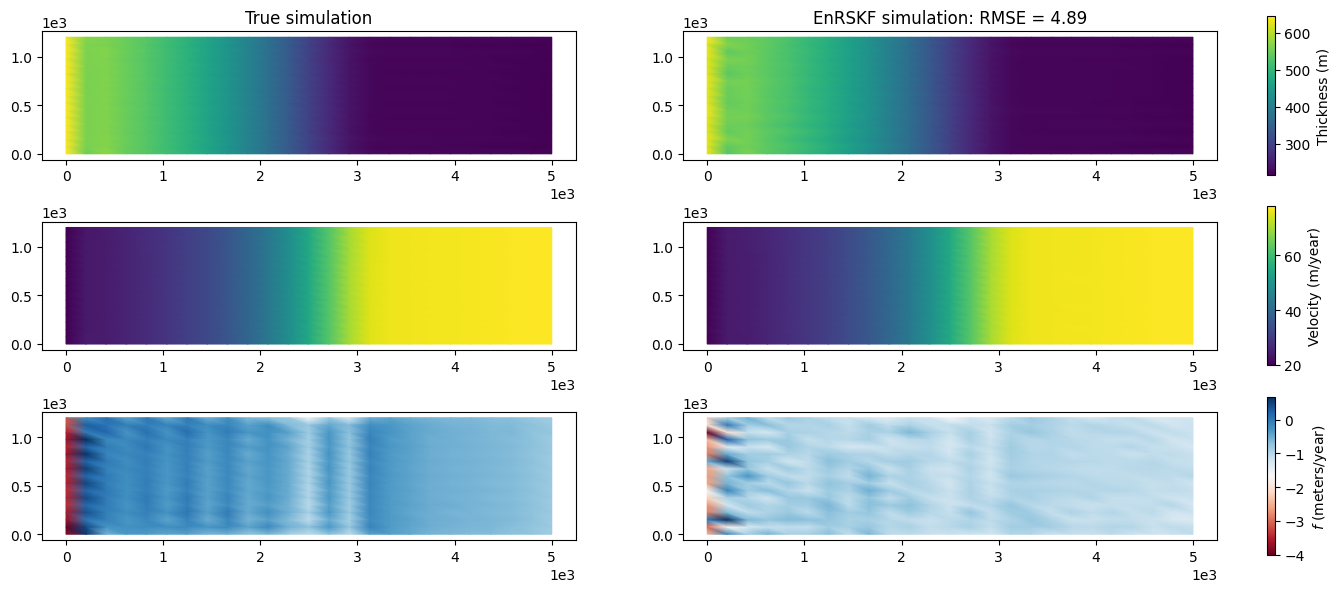

In [10]:
from firedrake import div
import icepack.plot
fig, axes = icepack.plot.subplots(3,2, figsize=(16,7))
step = params["nt"]
hhtrue = firedrake.Function(Q)
uutrue = firedrake.Function(V)
hhtrue.dat.data[:] = copy.deepcopy(statevec_true[:hdim,step])
colors = firedrake.tripcolor(hhtrue, axes=axes[0][0])
fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][0].set_title("True simulation")

# ploting the velocity field
uutrue.dat.data[:,0] = copy.deepcopy(statevec_true[hdim:2*hdim,step])
uutrue.dat.data[:,1] = copy.deepcopy(statevec_true[2*hdim:,step])
colors = firedrake.tripcolor(uutrue, axes=axes[1][0])
fig.colorbar(colors, ax=axes[1], fraction=0.012, pad=0.04, label="Velocity (m/year)")

# ploting the basal shear stress
f = firedrake.interpolate(a-div(hhtrue*uutrue), Q)
colors = firedrake.tripcolor(f, axes=axes[2][0], cmap="RdBu")
fig.colorbar(colors, ax=axes[2], fraction=0.012, pad=0.04, label=r"$f$ (meters/year)")

# axes[0][1].set_title("EnKF simulation")
axes[0][1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")
hhenkf = firedrake.Function(Q)
uuenkf = firedrake.Function(V)
hhenkf.dat.data[:] = copy.deepcopy(statevec_ens_mean[:hdim,step])
colors = firedrake.tripcolor(hhenkf, axes=axes[0][1])
# fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")


# ploting the velocity field
uuenkf.dat.data[:,0] = copy.deepcopy(statevec_ens_mean[hdim:2*hdim,step])
uuenkf.dat.data[:,1] = copy.deepcopy(statevec_ens_mean[2*hdim:,step])
colors = firedrake.tripcolor(uuenkf, axes=axes[1][1])


# ploting the basal shear stress
f = firedrake.interpolate(a-div(hhenkf*uuenkf), Q)
colors = firedrake.tripcolor(f, axes=axes[2][1], cmap="RdBu")



Text(0, 0.5, 'thickness (m)')

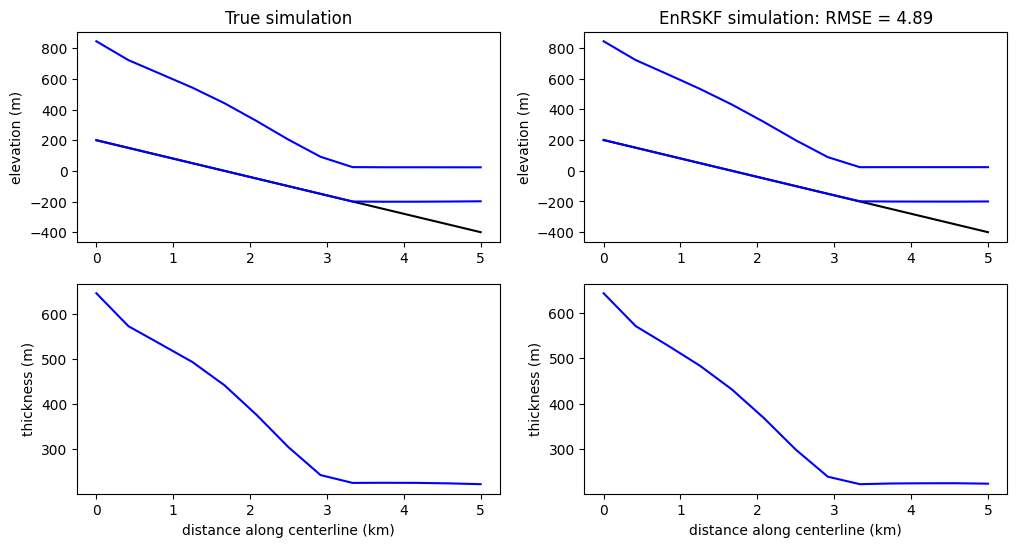

In [11]:
# we can draw some transects through the domain to see what the surface, bed, and ice base elevation look like

xs = np.array([(Lx * k /nx, 0) for k in range(nx + 1)])
s = icepack.compute_surface(thickness = hhtrue, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhtrue.at(xs, tolerance=1e-10))

fig, axes = plt.subplots(2,2, figsize=(12, 6))
axes[0,0].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,0].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,0].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,0].set_xlabel("distance along centerline (km)")
axes[0,0].set_ylabel("elevation (m)")
axes[0,0].set_title("True simulation")

axes[1,0].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,0].set_xlabel("distance along centerline (km)")
axes[1,0].set_ylabel("thickness (m)")


s = icepack.compute_surface(thickness = hhenkf, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhenkf.at(xs, tolerance=1e-10))

axes[0,1].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,1].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,1].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,1].set_xlabel("distance along centerline (km)")
axes[0,1].set_ylabel("elevation (m)")
# axes[0,1].set_title("DEnKF simulation")
axes[0,1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")

axes[1,1].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,1].set_xlabel("distance along centerline (km)")
axes[1,1].set_ylabel("thickness (m)")


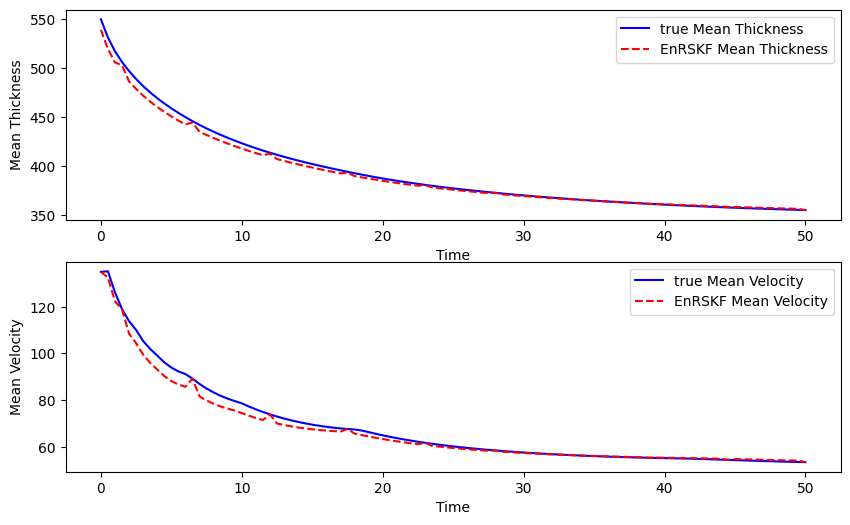

In [12]:
htrue = statevec_true[:hdim,:]
hens = statevec_ens_mean[:hdim,:]
# Calculate mean thickness across spatial points at each time step
mean_thickness      = np.mean(htrue, axis=0)
mean_thickness_ens  = np.mean(hens, axis=0)
h_ens_mean = np.mean(statevec_ens_full[:hdim,:,:],axis=0)
overall_mean = np.mean(h_ens_mean,axis=1)

fig, ax = plt.subplots(2,1, figsize=(10, 6))

# for ens in range(N):
    # ax[0].plot(ts,h_ens_mean[ens,:],label='EnKF Mean Thickness')

ax[0].plot(t, mean_thickness, 'b',label='true Mean Thickness')
# ax[0].plot(ts, mean_thickness_ens, '--r', label='DEnKF Mean Thickness')
ax[0].plot(t, mean_thickness_ens, '--r', label=f"{filter_type} Mean Thickness")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Mean Thickness')
# ax[0].set_title('Mean Thickness Over Time')
ax[0].legend()
# plt.show()

# velocity field
u_true = statevec_true[hdim:2*hdim,:]
v_true = statevec_true[2*hdim:,:]
utrue = np.sqrt(u_true**2 + v_true**2)
u_mean = np.mean(utrue, axis=0)
u_ens = statevec_ens_mean[hdim:2*hdim,:]
v_ens = statevec_ens_mean[2*hdim:,:]
uens = np.sqrt(u_ens**2 + v_ens**2)
u_ens_mean = np.mean(uens, axis=0)

ax[1].plot(t, u_mean, 'b',label='true Mean Velocity')
# ax[1].plot(ts, u_ens_mean, '--r', label='DEnKF Mean Velocity')
ax[1].plot(t, u_ens_mean, '--r', label=f"{filter_type} Mean Velocity")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Mean Velocity')
# ax[1].set_title('Mean Velocity Over Time')
ax[1].legend()

Text(0, 0.5, 'Velocity')

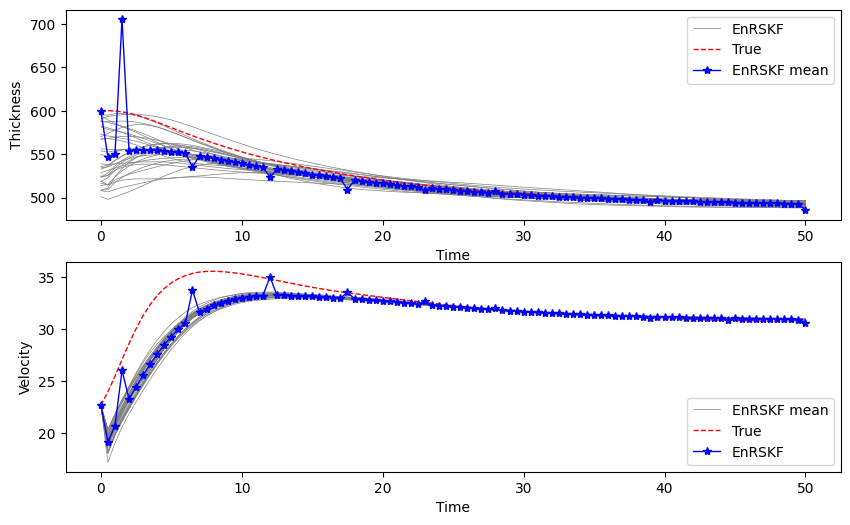

In [14]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

h_obs = utils_funs.Obs_fun(hu_obs[:hdim,:])

# plot the h middle profile
h_indx = hens.shape[1]//2
h_true = htrue[h_indx,:]
h_ens_mean = hens[h_indx,:]
h_ens_mem  = statevec_ens_full[h_indx,:,:].T
# h_ob = h_ob[-1,:]
for ens in range(N):
    ax[0].plot(t,h_ens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

# ax[0].plot(ts,h_ens_mem[:,:], lw=0.5, color='k',label="DEnKF ens")
ax[0].plot(t,h_true,'--r',label='True',linewidth=1)
ax[0].plot(t,h_ens_mean,'-*b',label=f"{filter_type} mean",linewidth=1)
# ax[0].plot(t[ind_m],hu_ob[1,:],'kx',label='Observations')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Thickness')

# plot the u middle profile
u_ob = utils_funs.Obs_fun(hu_obs[hdim:2*hdim,:])
v_ob = utils_funs.Obs_fun(hu_obs[2*hdim:,:])
uobs = np.sqrt(u_ob**2 + v_ob**2)
u_indx = hdim + h_indx
v_indx = 2*hdim + h_indx
u_true = statevec_true[u_indx,:]
v_true = statevec_true[v_indx,:]
utrue = np.sqrt(u_true**2 + v_true**2)
u_ens_mean = statevec_ens_mean[u_indx,:]
v_ens_mean = statevec_ens_mean[v_indx,:]
uens_mean = np.sqrt(u_ens_mean**2 + v_ens_mean**2)
u_ens_mem  = statevec_ens_full[u_indx,:,:].T
v_ens_mem  = statevec_ens_full[v_indx,:,:].T
uens_mem = np.sqrt(u_ens_mem**2 + v_ens_mem**2)
for ens in range(N):
    ax[1].plot(t,uens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type} mean" if ens == 0 else "")

ax[1].plot(t,utrue,'--r',label='True',linewidth=1)
ax[1].plot(t,uens_mean,'-*b',label=f"{filter_type}",linewidth=1)
# ax[1].plot(t[ind_m],uobs[1,:],'kx',label='Observations')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
